**Import MNIST Fashion dataset**

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
# Use your kaggle API key here to download the dataset
from google.colab import files
files.upload()

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d zalando-research/fashionmnist
!ls

In [6]:
!unzip fashionmnist.zip

Archive:  fashionmnist.zip
  inflating: t10k-images-idx3-ubyte  
  inflating: fashion-mnist_test.csv  
  inflating: train-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-labels-idx1-ubyte  


In [0]:
import pandas as pd

df_train = pd.read_csv('fashion-mnist_train.csv')
target_train = df_train.pop('label')
features_train = df_train

df_test = pd.read_csv('fashion-mnist_test.csv')
target_test = df_test.pop('label')
features_test = df_test

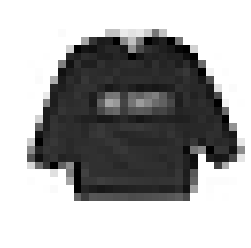

Label: 2


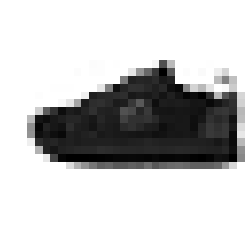

Label: 7


In [8]:
# View the first image
import numpy as np
import matplotlib.pyplot as plt

first_image = features_train.iloc[0]
first_image = np.array(first_image, dtype = "float")
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap = "gray_r")
plt.axis("off")
plt.show()
print ("Label:", target_train.iloc[0])

# View last image 
last_image = features_train.iloc[-1]
last_image = np.array(last_image, dtype = "float")
pixels = last_image.reshape((28, 28))
plt.imshow(pixels, cmap = "gray_r")
plt.axis("off")
plt.show()
print ("Label:", target_train.iloc[-1])

In [0]:
# Use sklearn StandardScaler to scale pixel values
from sklearn.preprocessing import StandardScaler
# Create scale object
scaler = StandardScaler()
# Fit scaler to training data only
scaler_fit = scaler.fit(features_train)
# Transform both train and test data with the trained scaler
X_train = scaler_fit.transform(features_train)
X_test = scaler_fit.transform(features_test)

**Baseline model**

In [11]:
import xgboost as xgb
from sklearn.metrics import f1_score, accuracy_score

# Create XGB Classifier object
xgb_clf = xgb.XGBClassifier(objective = "multi:softmax")
# Fit model
xgb_model = xgb_clf.fit(X_train, target_train)
# Predictions
y_train_preds = xgb_model.predict(X_train)
y_test_preds = xgb_model.predict(X_test)
# Print F1 scores and Accuracy
print("Training F1 Micro Average: ", f1_score(target_train, y_train_preds, average = "micro"))
print("Test F1 Micro Average: ", f1_score(target_test, y_test_preds, average = "micro"))
print("Test Accuracy: ", accuracy_score(target_test, y_test_preds))

Training F1 Micro Average:  0.8788333333333334
Test F1 Micro Average:  0.8674
Test Accuracy:  0.8674


**Hyperparameter Tuning**

In [0]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Create XGB Classifier object
xgb_clf = xgb.XGBClassifier(tree_method = "gpu_exact", predictor = "gpu_predictor", silent = True,
                           eval_metric = ["merror", "map", "auc"], objective = "multi:softmax")
# Create parameter grid
parameters = {"learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [2, 4, 7, 10],
               "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "reg_alpha": [0, 0.5, 1],
               "reg_lambda": [1, 1.5, 2, 3, 4.5],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators": [100, 250, 500, 1000]}

# Create RandomizedSearchCV Object
xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
                             cv = 7, verbose = 3, random_state = 40)

# Fit the model
model_xgboost = xgb_rscv.fit(X_train, target_train)

**Grid Search for hyperparameter Tuning**

In [0]:
# Create XGB Classifier object
xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "cpu_predictor", verbosity = True,
                            objective = "multi:softmax")

# Create parameter grid
parameters = {"learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [2, 4, 7, 10],
               "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "reg_alpha": [0, 0.5, 1],
               "reg_lambda": [1, 1.5, 2, 3, 4.5],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators": [100, 250, 500, 1000]}

from sklearn.model_selection import RandomizedSearchCV
# Create RandomizedSearchCV Object
xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
                             cv = 10, verbose = 3, random_state = 40 )

# Fit the model
model_xgboost = xgb_rscv.fit(X_train, target_train)

# Model best estimators
print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
print("Max Features at Split: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
print("Minimum Sum of the Instance Weight Hessian to Make a Child: ",
      model_xgboost.best_estimator_.get_params()["min_child_weight"])
print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])